Metadata:
label: LTE
frequency: 751000000.0
sample_rate: 60000000.0
gain: 76
bandwidth: 60000000.0
fft_averaging: 16
timestamp: 20240817_112813


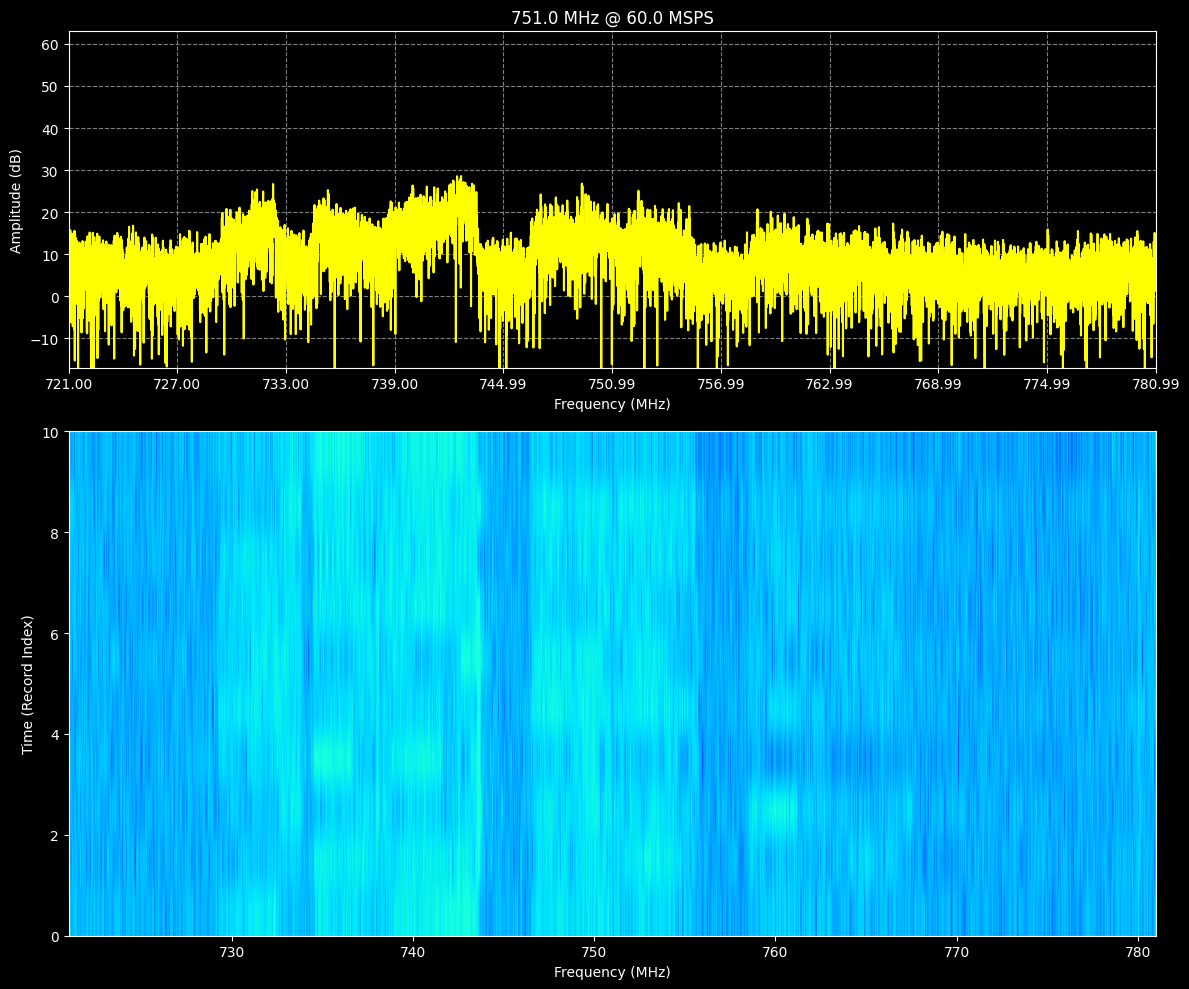

In [24]:
# Import necessary libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# Set the matplotlib theme to dark mode
plt.style.use('dark_background')

# Load the pickle file
file_path = "/root/datascience/recordings/LTE_20240817_112813.pkl"

with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract metadata and records
metadata = data['metadata']
records = data['records']

# Display metadata
print("Metadata:")
for key, value in metadata.items():
    print(f"{key}: {value}")

# Calculate the noise floor based on the averaging of all records
all_fft_data = np.array([record['fft_magnitude'] for record in records])
averaged_fft_data = np.mean(all_fft_data, axis=0)
noise_floor = np.mean(np.sort(averaged_fft_data)[:int(len(averaged_fft_data) * 0.2)])  # Use the lowest 20% of FFT values

# Set the plot ranges
lower_plot_range = noise_floor - 20  # 20 dB below the noise floor
upper_plot_range = noise_floor + 60  # 60 dB above the noise floor

# Calculate the left and right frequency bounds
freq_bound_left = metadata['frequency'] / 1e6 - metadata['sample_rate'] / 2e6
freq_bound_right = metadata['frequency'] / 1e6 + metadata['sample_rate'] / 2e6

# Function to plot the first FFT and the waterfall of all FFT records
def plot_fft_and_waterfall(records, metadata, nfft=1024, noverlap=512):
    fig, (ax_fft, ax_waterfall) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1.5]})

    # Calculate the frequency array (centered at 0)
    fft_magnitude = np.array(records[0]['fft_magnitude'])
    freq = np.fft.fftshift(np.fft.fftfreq(len(fft_magnitude), d=1/metadata['sample_rate'])) / 1e6

    # Plot the FFT magnitude spectrum of the first record
    ax_fft.plot(freq, fft_magnitude, color='yellow')  # Plot in yellow
    ax_fft.set_title(f"{metadata['frequency']/1e6} MHz @ {metadata['sample_rate']/1e6} MSPS")
    ax_fft.set_xlabel("Frequency (MHz)")
    ax_fft.set_ylabel("Amplitude (dB)")
    ax_fft.set_ylim(lower_plot_range, upper_plot_range)
    ax_fft.set_xlim(freq.min(), freq.max())  # Keep x-axis limits based on original FFT frequencies
    ax_fft.set_xticks(freq[::len(freq) // 10])  # Set x-ticks to be spread out

    # Adjust the x-tick labels to reflect the actual frequency range
    actual_freq = freq + metadata['frequency'] / 1e6
    ax_fft.set_xticklabels([f"{f:.2f}" for f in actual_freq[::len(actual_freq) // 10]])  # Label with actual frequencies

    ax_fft.grid(True, color='gray', linestyle='--')

    # Prepare the waterfall data by stacking all FFT records vertically
    waterfall_data = np.vstack([record['fft_magnitude'] for record in records])

    # Flip the waterfall data to display from top to bottom
    waterfall_data = np.flipud(waterfall_data)

    # Plot the waterfall (frequency on X-axis, time on Y-axis)
    extent = [freq_bound_left, freq_bound_right, 0, len(records)]
    ax_waterfall.imshow(10 * np.log10(np.abs(waterfall_data)), aspect='auto', extent=extent, cmap='jet', vmin=lower_plot_range, vmax=upper_plot_range)
    ax_waterfall.set_xlabel("Frequency (MHz)")
    ax_waterfall.set_ylabel("Time (Record Index)")

    # Remove the colorbar and title
    ax_waterfall.set_title('')

    plt.tight_layout()
    plt.show()

# Plot the combined FFT and Waterfall
plot_fft_and_waterfall(records, metadata)
